# 画像生成 AI 入門: Python による拡散モデルの理論と実践

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shunk031/coloso-python-diffusion-models/blob/main/lectures/section-03-10.ipynb)


## Section 03: Basics of Diffusion Model

最先端の画像生成 AI である拡散モデル (diffusion model) の基礎について導入します。

### Lecture 10: Denoising Diffusion Probabilistic Model (2)

現在注目されている画像生成 AI の元になっているノイズ除去拡散確率モデル (denoising diffusion probabilistic model: DDPM) を改良したノイズ除去拡散暗黙モデル (denoising diffusion implicit model: DDIM) について、`diffusers` で実際に動かしてみます。

## セットアップ

## GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [ ]:
!nvidia-smi

Tue Jun  6 14:08:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

diffusers ライブラリをインストールすることで拡散モデルを簡単に使用できるようにします。diffusers ライブラリを動かす上で必要となライブラリも追加でインストールします:
  - [accelerate](https://github.com/huggingface/accelerate): transformers と連携してより高速な画像生成をサポートするライブラリ

In [ ]:
!pip install diffusers==0.16.1
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## DDPM で画像生成

まずは前回の講義同様に、ハリウッドスターの顔画像で学習された DDPM を読み込んで画像を生成してみます。

In [ ]:
from diffusers import DDPMPipeline

model_id = "google/ddpm-celebahq-256"

ddpm_pipe = DDPMPipeline.from_pretrained(model_id)
ddpm_pipe = ddpm_pipe.to("cuda")

DDPM と DDIM で生成結果の比較と再現性を担保するためにシードを固定するための generator を定義しておきます。

In [ ]:
import torch

generator = torch.Generator("cuda").manual_seed(19950815)

まずは前回の講義同様の設定で DDPM に画像を生成させてみます。1000 ステップを要するために、画像生成に時間がかかります。

In [ ]:
image = ddpm_pipe(num_inference_steps=1000, generator=generator).images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

前回の講義で確認した通り、ハリウッドスターのような画像が生成されました。

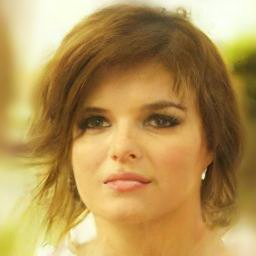

In [ ]:
image

DDPM においてデフォルトでは 1000 ステップが必要でしたが、今度はステップ数を 50 に設定しました。このステップ数は DDIM のデフォルト値です。先程定義した generator もパイプラインに渡して画像を生成してもらいましょう。

  0%|          | 0/50 [00:00<?, ?it/s]

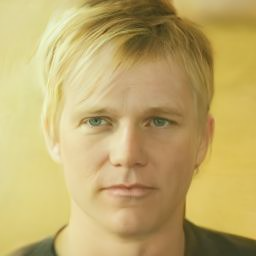

In [ ]:
image = ddpm_pipe(num_inference_steps=50, generator=generator).images[0]
image

生成された画像を確認してみましょう。ある程度は顔画像のように見えますが、輪郭や背景などが曖昧で、詳細な情報をまだ上手く描画できていないような画像が生成されるはずです。

## DDIM で画像生成

では次に DDPM を改良した DDIM を実際に動かします。DDPM 同様にハリウッドスターで学習された事前学習済みパラメータを `DDIMPipeline` で読み込ませます。DDIM は DDPM とほとんど同様のアーキテクチャを有するため、DDPM で学習されたパラメータも一部読み込むことができます。

In [ ]:
from diffusers import DDIMPipeline

model_id = "google/ddpm-celebahq-256"

ddim_pipe = DDIMPipeline.from_pretrained(model_id)
ddim_pipe = ddim_pipe.to("cuda")

DDIM は DDPM と比べて少ないステップ数でより良い画像を生成できるという利点がありました。実際にステップ数を DDPM のデフォルトである 1000 より大幅に少なくした 50 で確認してみます。

  0%|          | 0/50 [00:00<?, ?it/s]

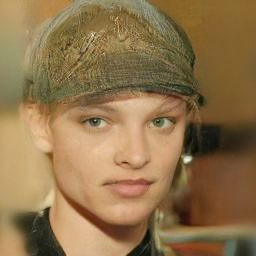

In [ ]:
image = ddim_pipe(num_inference_steps=50, generator=generator).images[0]
image

生成された画像を確認してみましょう。ステップ数を大幅に少なくしたにも関わらず、DDPM でステップ数 1000 で生成したときのような画像が生成されたことを確認してください。